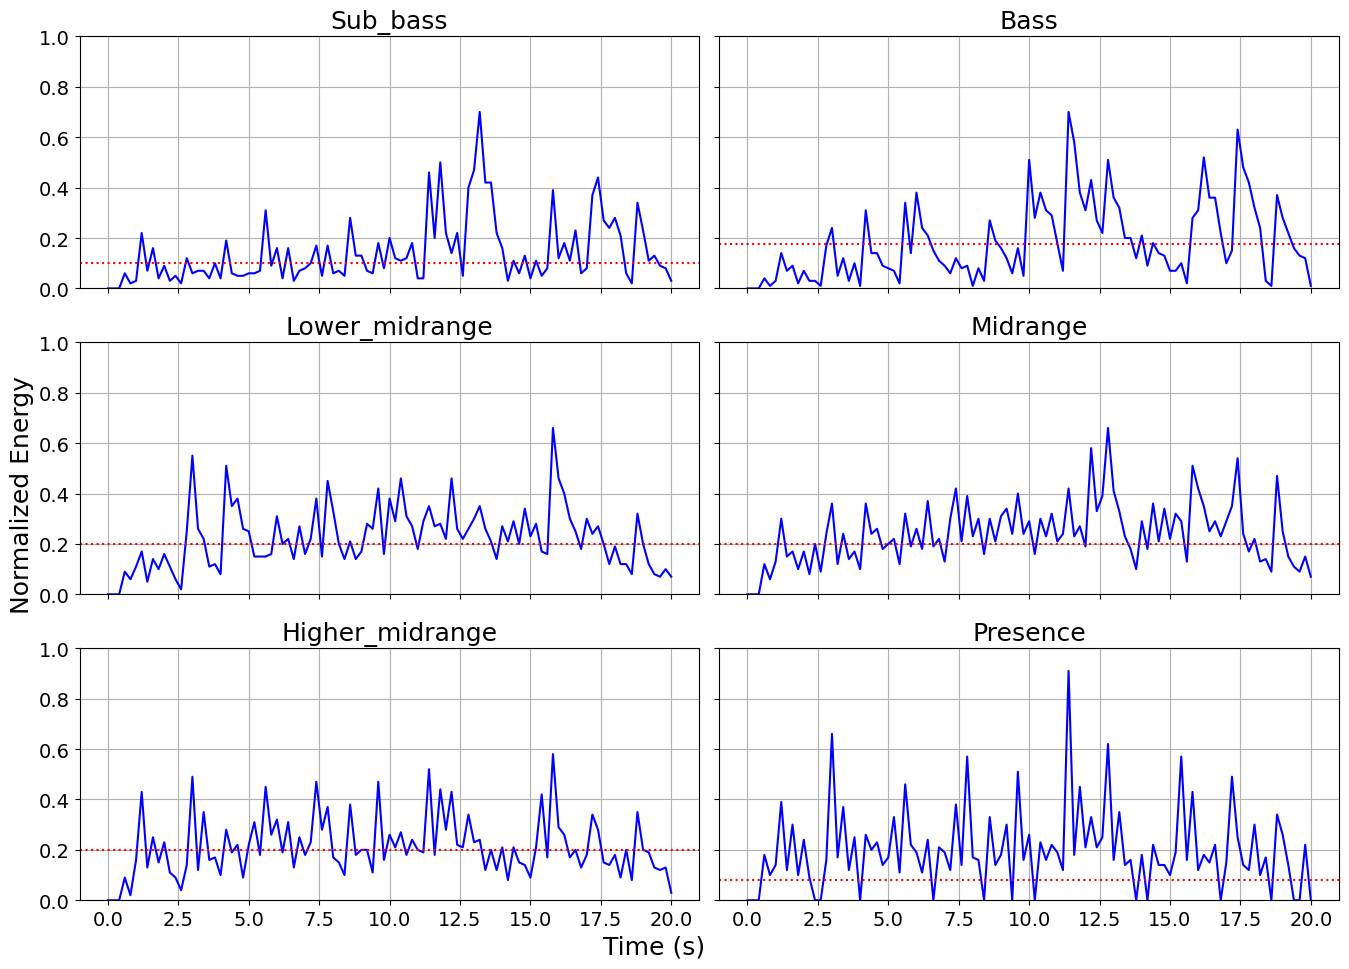

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def extract_features(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Define the hop length (number of samples per time-step)
    hop_length = int(0.200 * sr)  # 200 ms window
    
    # Apply STFT
    D = np.abs(librosa.stft(y, hop_length=hop_length))
    
    # Frequency bins
    freqs = librosa.fft_frequencies(sr=sr)
    
    # Define frequency ranges
    ranges = {
        "sub_bass": (20, 60),
        "bass": (60, 250),
        "lower_midrange": (250, 500),
        "midrange": (500, 2000),
        "higher_midrange": (2000, 4000),
        "presence": (4000, 6000),
        "brilliance": (6000, 20000),
    }
    
    # Calculate the time for each column in D
    times = librosa.frames_to_time(range(D.shape[1]), sr=sr, hop_length=hop_length)
    
    # Initialize the output dictionary
    energy_by_range = []
    
    # Extract energy in the specified frequency ranges for each time-step
    for i, time in enumerate(times):
        features = {"time": float(time)}  # Convert to Python float
        for name, (low, high) in ranges.items():
            # Find the indices of the frequency bins that fall into the current range
            indices = np.where((freqs >= low) & (freqs <= high))[0]
            # Calculate the average energy in this frequency range
            energy = np.mean(D[indices, i])
            features[name] = float(energy)  # Convert to Python float
        
        energy_by_range.append(features)
    
    return energy_by_range

def normalize_and_adjust(data):
    # Adjust values lower than 0.01 to 0
    for entry in data:
        for key, value in entry.items():
            if key != 'time':  # Apply adjustment to relevant fields only
                if value < 0.01:
                    entry[key] = 0.0

    # Initialize a dictionary to store min and max values for each key
    min_max_values = {}

    # Find the min and max for each field after adjustment
    for entry in data:
        for key, value in entry.items():
            if key != 'time':
                if key in min_max_values:
                    min_max_values[key]['min'] = min(min_max_values[key]['min'], value)
                    min_max_values[key]['max'] = max(min_max_values[key]['max'], value)
                else:
                    min_max_values[key] = {'min': value, 'max': value}

    # Normalize the values and cut to the hundredths digit
    for entry in data:
        for key, value in entry.items():
            if key != 'time':
                min_val = min_max_values[key]['min']
                max_val = min_max_values[key]['max']
                # Avoid division by zero if min and max are the same
                if max_val - min_val != 0:
                    normalized_value = (value - min_val) / (max_val - min_val)
                    # Round to the hundredths place
                    entry[key] = round(normalized_value, 2)
                else:
                    entry[key] = 0.0

    return data

def plot_energy_with_horizontal_lines(processed_data):
    # Filter data for the first 20 seconds
    filtered_data = [entry for entry in processed_data if entry['time'] <= 20]

    # Extract time values from filtered data
    time_values = [entry['time'] for entry in filtered_data]

    # Setup figure with 6 subplots in a 3x2 grid layout
    fig, axs = plt.subplots(3, 2, figsize=(14, 10), sharex=True, sharey=True)
    axs = axs.ravel()  # Flatten grid for easy indexing

    # Define specific y-values for horizontal lines
#     horizontal_lines = {
#         'sub_bass': 0.009,
#         'bass': 0.175,
#         'lower_midrange': 0.2,
#         'midrange': 0.2,
#         'higher_midrange': 0.2,
#         'presence': 0.08
#     }
    horizontal_lines = {
        'sub_bass': 0.1,
        'bass': 0.175,
        'lower_midrange': 0.2,
        'midrange': 0.2,
        'higher_midrange': 0.2,
        'presence': 0.08
    }

    # Loop through each key except 'time' and 'brilliance' to plot
    keys = [key for key in processed_data[0].keys() if key not in ['time', 'brilliance']]
    for i, key in enumerate(keys):
        energy_values = [entry[key] for entry in filtered_data]

        # Plot each frequency range
        axs[i].plot(time_values, energy_values, label=key, color='blue')
        axs[i].axhline(y=horizontal_lines[key], color='red', linestyle=':', linewidth=1.5)  # Add dotted line
        axs[i].set_title(key.capitalize(), fontsize=18)
        axs[i].grid(True)
        axs[i].set_ylim(0, 1)  # Limit y-axis for normalized values
        
        # Increase font size of axis numbers (tick labels)
        axs[i].tick_params(axis='both', labelsize=14)

    # Set common labels for the entire figure
    fig.text(0.5, 0.04, "Time (s)", ha="center", fontsize=18)
    fig.text(0.04, 0.5, "Normalized Energy", va="center", rotation="vertical", fontsize=18)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.show()

filename = "forestofblocks"
audio_path = f"D://Aaron Alcuitas/ACADEMICS/Masters/lab/{filename}.mp3"
energy_data = extract_features(audio_path)
processed_data = normalize_and_adjust(energy_data)
plot_energy_with_horizontal_lines(processed_data)